In [71]:
import datetime
import numpy as np
import pandas as pd
import yfinance as yf
import vartools as vt

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display
from sklearn.linear_model import LinearRegression

# Datos

In [72]:
tickers = ['AAPL', 'WMT', 'JPM', 'PG', 'META', 'V']
benchmark = '^GSPC'

price = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Close'][tickers]
volume = yf.download(tickers, start='2021-01-01', end='2025-03-12', progress=False)['Volume'][tickers]

benchmark_data = yf.download(benchmark, start='2021-01-01', end='2025-03-12', progress=False)['Close']

rt = price.pct_change().dropna()
rt_benchmark = benchmark_data.pct_change().dropna()

In [73]:
print(f'Precios de los activos')
display(price.head())
print()

print(f'Volumen de los activos')
display(volume.head());

Precios de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,126.405251,46.071339,112.308487,124.070045,267.916565,211.141388
2021-01-05,127.968063,45.826092,112.919586,124.862206,269.938873,207.990173
2021-01-06,123.660461,46.112202,118.221832,126.176559,262.307983,206.157639
2021-01-07,127.880188,46.109051,122.104118,124.997261,267.717346,207.311462
2021-01-08,128.983917,46.102772,122.238953,124.943245,266.551819,208.901611



Volumen de los activos


Ticker,AAPL,WMT,JPM,PG,META,V
Date,,,,,,
2021-01-04,143301900,32182200,16819900,8330900,15106100,10318300
2021-01-05,97664900,26498100,13731200,6856400,9871600,6869700
2021-01-06,155088000,21918900,24909100,10578000,24354100,7206200
2021-01-07,109578200,20538000,21940400,7355400,15789800,10967900
2021-01-08,105158200,24478200,12035100,7448500,18528300,6513000


In [74]:
pd.set_option('display.float_format', '{:.2%}'.format)
stats_df = pd.DataFrame({
    'Rendimiento Anual': rt.mean() * 252,
    'Volatilidad Anual': rt.std() * np.sqrt(252),
})
stats_df.T

Ticker,AAPL,WMT,JPM,PG,META,V
Rendimiento Anual,16.96%,17.44%,20.03%,9.45%,29.47%,13.41%
Volatilidad Anual,26.74%,20.19%,24.16%,17.05%,44.15%,22.53%


# Optimización

## Sharpe

In [75]:
def opt_sharpe(rt, rf):
    mu = rt.mean().values * 252  
    cov = rt.cov().values 
    n = len(rt.keys())

    def sharpe(w, mu, cov, rf):
        mu_port = np.dot(mu, w)
        sigma_port = np.sqrt(np.dot(w.T, np.dot(cov * 252, w)))
        return -(mu_port - rf) / sigma_port  

    def sum_weights(w):
        return np.sum(w) - 1

    w0 = np.array([1 / n] * n) 

    restricciones = [{'type': 'eq', 'fun': sum_weights}]

    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(sharpe, 
                      w0,
                      args=(mu, cov, rf),  
                      constraints=restricciones,
                      bounds=bounds, 
                      method='SLSQP'
    )

    w_sharpe = result.x
    return w_sharpe

## LVRR

In [76]:
def opt_lvrr(price, volume, rt, rf, pv):
    mu = rt.mean().values * 252  
    cov = rt.cov().values 
    n = len(rt.keys())

    adv = volume.loc[volume.index >= volume.index.max() - pd.DateOffset(months=3)].mean()

    def lvrr(w, mu, cov, rf, pv, adv):
        mu_port = np.dot(mu, w)
        sigma_port = np.sqrt(np.dot(w.T, np.dot(cov * 252, w)))
        sharpe = (mu_port - rf) / sigma_port

        Ndays = (np.floor(pv * w / price.iloc[-1]))/adv
        #Ndays = (pv * w / price.iloc[-1])/adv
        return -(sharpe / np.sum(Ndays))

    def sum_weights(w):
        return np.sum(w) - 1

    w0 = np.array([1 / n] * n) 

    restricciones = [{'type': 'eq', 'fun': sum_weights}]

    bounds = tuple((0, 1) for _ in range(n))

    result = minimize(lvrr, 
                      w0,
                      args=(mu, cov, rf, pv, adv),  
                      constraints=restricciones,
                      bounds=bounds, 
                      method='SLSQP'
    )

    w_lvrr = result.x
    return w_lvrr

## Resultados

In [77]:
pd.reset_option('display.float_format')

rf = 0.05
pv = 1000000.0

start_date = '2021-01-01'
end_date = '2023-12-31'

start_test = '2024-01-01'
end_test = '2025-03-12'
#end_test = datetime.datetime.today().strftime('%Y-%m-%d')

benchmark_test = benchmark_data.loc[start_test:end_test]

price_train = price.loc[start_date:end_date]
price_test = price.loc[start_test:end_test]

volume_train = volume.loc[start_date:end_date]
volume_test = volume.loc[start_test:end_test]

rt_train = price_train.pct_change().dropna()
rt_test = price_test.pct_change().dropna()
rt_benchmark_test = benchmark_test.pct_change().dropna()

### Sharpe

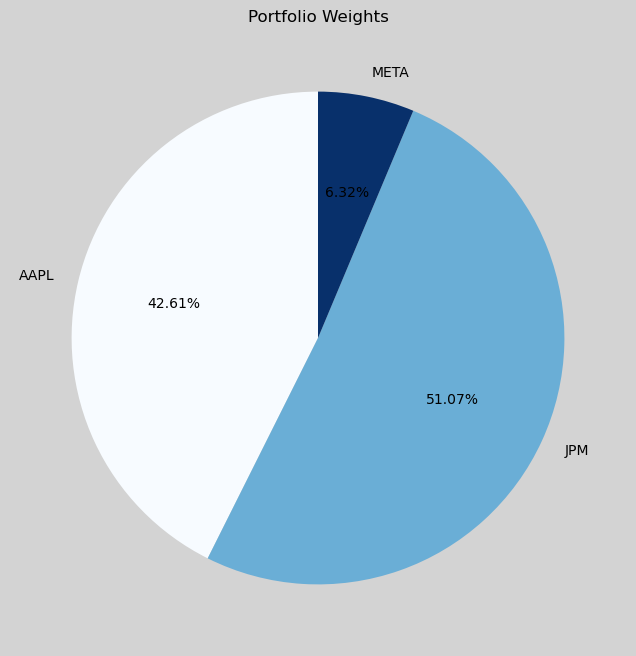

In [78]:
vt.plot_weights(tickers, opt_sharpe(rt_train, rf))

### LVRR

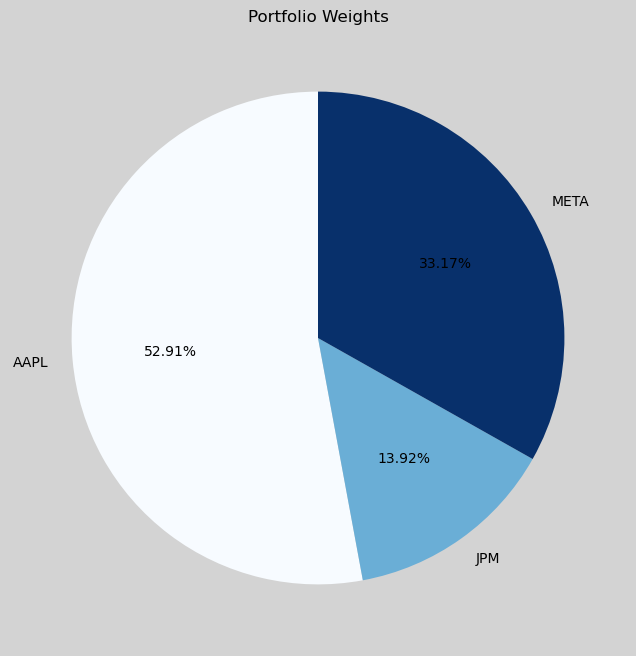

In [79]:
vt.plot_weights(tickers, opt_lvrr(price_train, volume_train, rt_train, rf, pv))